# Zero-shot reference mapping tutorial with scGPT

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under `data` directory in the outer level.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y). 


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Generate scGPT embeddings for each cell in reference and query datasets

 3. Transfer the annotations from reference to query dataset

At the [appendix](#appendix-reference-mapping-on-lung-kim-dataset) of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).


We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb)

In [1]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain faiss-cpu

    # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "covid")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS",
            output=os.path.join(data_dir),
        )
    if not os.path.exists(os.path.join(data_dir, "lung")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO",
            output=os.path.join(data_dir),
        )

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_human"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
            output=model_dir,
        )

## Import scGPT and dependencies

In [2]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [3]:
modelPath = Path(f"/tscc/nfs/home/s5srinivasan/scgpt-project/covid-annotation-scgpt/save/randomModel") # use of random model
dataDir = Path(f"/tscc/nfs/home/s5srinivasan/scratch") # setting up data and project directories

referenceData = sc.read(dataDir / "covidData.h5ad") # Mukund et al. reference dataset
queryData = sc.read(dataDir / "may24_covid19.h5ad") # May et al. query dataset

projectDir = Path(f"/tscc/nfs/home/s5srinivasan/scgpt-project/covid-annotation-scgpt")

In [4]:
queryData.var.rename(columns={'gene_symbol':'gene_name'}, inplace=True)
queryData.obs.rename(columns={'cell_type':'celltype'}, inplace=True)
queryData.var_names = queryData.var["gene_name"]

In [5]:
queryData.var

,gene_name,gene_id
gene_name,,
ABCB1,ABCB1,ENSG00000085563
ABCC1.0.PolyA_1,ABCC1.0.PolyA_1,ENSG00000103222.0.PolyA_1
ABCC1.0.ref,ABCC1.0.ref,ENSG00000103222.0.ref
ABCC1.1,ABCC1.1,ENSG00000103222.1
AHR,AHR,ENSG00000106546
...,...,...
ZBTB16,ZBTB16,ENSG00000109906
ZBTB7B,ZBTB7B,ENSG00000160685
ZEB2.0.PolyA_1,ZEB2.0.PolyA_1,ENSG00000169554.0.PolyA_1


In [6]:
cell_type_key = "celltype"
gene_col = "gene_name"

Embed the reference dataset

In [7]:
ref_embed_referenceData = scg.tasks.embed_data(
    referenceData,
    modelPath,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 13704/14063 genes in vocabulary of size 60697.


/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 5867/5867 [13:11<00:00,  7.42it/s]
/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


Embed the query dataset

In [8]:
test_embed_queryData = scg.tasks.embed_data(
    queryData,
    modelPath,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 316/365 genes in vocabulary of size 60697.


/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 1227/1227 [00:30<00:00, 40.50it/s]
/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Mark the reference vs. query cells and mask the cell types on query cells

In [9]:
# concatenate the two datasets
referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")

/tmp/ipykernel_3157778/3134427906.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")


In [10]:
# mark the reference vs. query dataset
referenceData_concat.obs["is_ref"] = ["Query"] * len(test_embed_queryData) + ["Reference"] * len(
    ref_embed_referenceData
)
referenceData_concat.obs["is_ref"] = referenceData_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].astype("category")
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"

/tmp/ipykernel_3157778/3863382858.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"


In [11]:
referenceData_concat.obs

,celltype,clinical_score,timepoint,Clinical Score,Age,Race,Ethnicity,BMI,Sex,HospitalStay,...,log10GenesPerUMI,percent.mt,percent.Heme,Study,seurat_clusters,new.annot2,celltype_id,batch_id,dataset,is_ref
76760-0-0-0,To be predicted,17,week2,17.0,42.0,White,Unknown or not documented,25.0-29.9 (overweight),Male,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
754815-0-0-0,To be predicted,17,week2,17.0,42.0,White,Unknown or not documented,25.0-29.9 (overweight),Male,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
59176-0-0-0,To be predicted,17,week2,17.0,42.0,White,Unknown or not documented,25.0-29.9 (overweight),Male,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
218313-0-0-0,To be predicted,17,week2,17.0,42.0,White,Unknown or not documented,25.0-29.9 (overweight),Male,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
501127-0-0-0,To be predicted,17,week2,17.0,42.0,White,Unknown or not documented,25.0-29.9 (overweight),Male,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTACCTTACACTCGAGAAAGGGTCAG_22_5-1,MAIT cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.882532,21.009867,0.000000,SS_C2,15.0,8.0,9.0,3.0,1,Reference
AACTGTATTACTATCCTCCTAGATAGA_22_5-1,CD14+ Monocytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.907000,20.129870,0.779221,SS_C2,23.0,4.0,1.0,3.0,1,Reference
CACATTGCAGCTAACTCACAGGCATTT_22_5-1,CD14+ Monocytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.931754,17.892644,0.397614,SS_C2,23.0,4.0,1.0,3.0,1,Reference
TCTCTTCAACAATTGATCAGCCGCAAG_22_5-1,CD8+ T cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.940330,13.244353,0.410678,SS_C2,31.0,2.0,5.0,3.0,1,Reference


## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

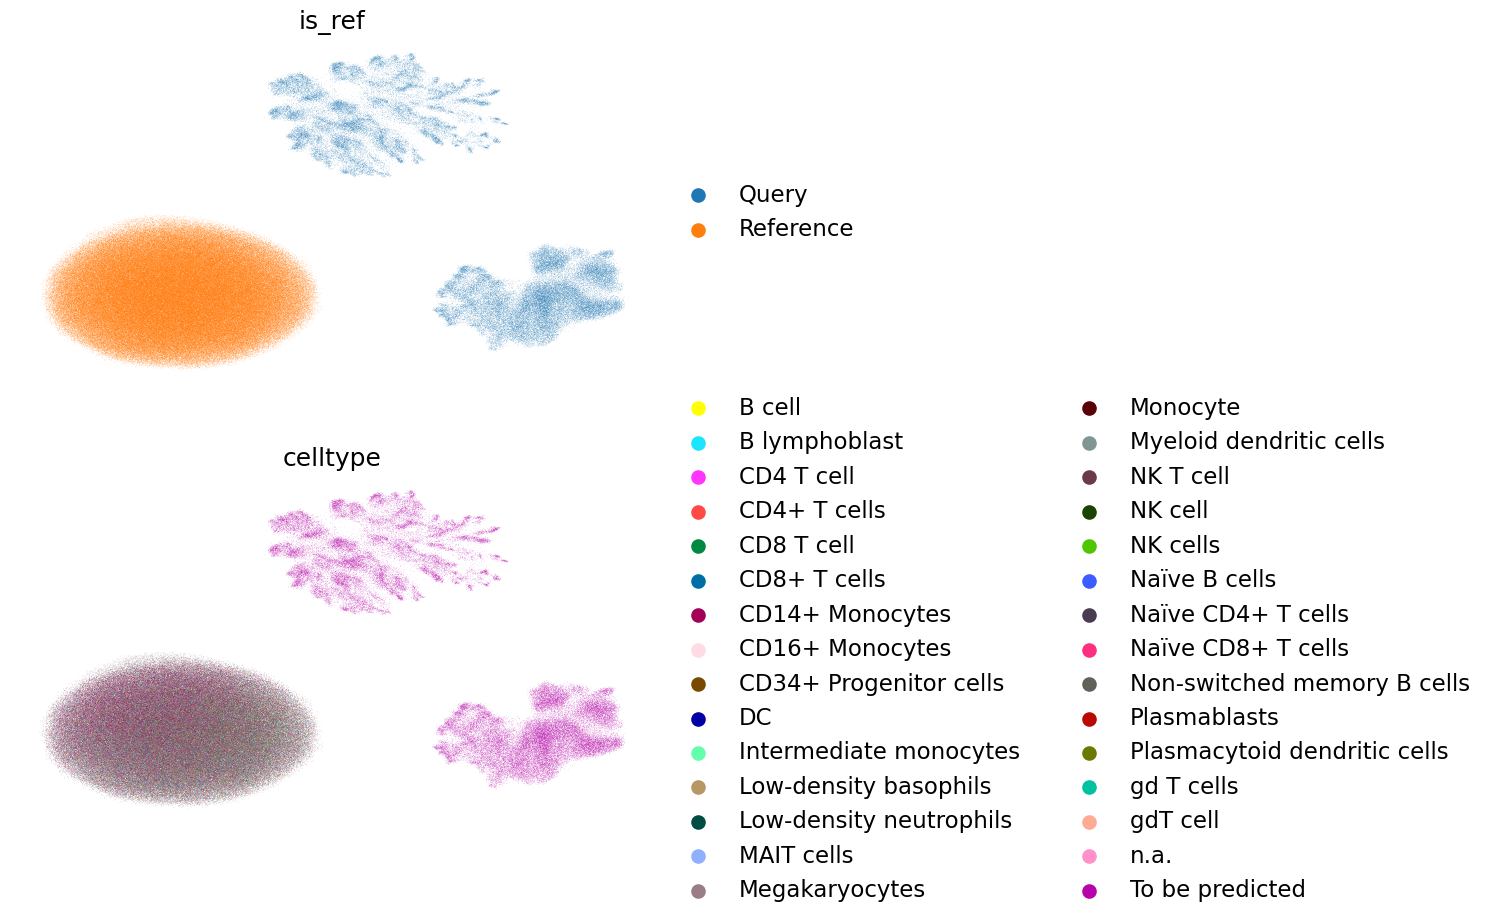

In [12]:
sc.pp.neighbors(referenceData_concat, use_rep="X_scGPT")
sc.tl.umap(referenceData_concat)
sc.pl.umap(
    referenceData_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations

Run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [13]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [14]:
import faiss
import tqdm

In [33]:
ref_cell_embeddings = ref_embed_referenceData.obsm["X_scGPT"]
test_embed = test_embed_queryData.obsm["X_scGPT"]

k = 5  # number of neighbors

In [34]:
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

In [44]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x1551574c9b40> >

In [35]:
# Transfer the index to GPU
res = faiss.StandardGpuResources()  # Create resources for GPU
index_gpu = faiss.index_cpu_to_gpu(res, 0, index)  # Move index to GPU 0

In [36]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays) - GPU implementation
distances, labels = index_gpu.search(test_embed, k) # 

In [37]:
############### MOVED TO GPU ########################
import torch 
from sklearn.preprocessing import LabelEncoder

# Ensure both the query data (test_embed) and reference data (ref_cell_embeddings) are on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transfer data to the GPU
test_embed = torch.tensor(test_embed).to(device)
ref_cell_embeddings = torch.tensor(ref_cell_embeddings).to(device)

# Initialize or load the Faiss index and move it to GPU if needed
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])  # Example index, use the correct one
index_gpu = faiss.index_cpu_to_gpu(res, 0, index)  # Transfer to GPU

# Perform the search (GPU-based)
distances, labels = index_gpu.search(test_embed.cpu().numpy(), k)  # Move tensor to CPU before converting to NumPy

# Initialize lists to store predictions and similarity scores
preds = []
sim_list = distances

# Assuming cell_type_key contains string labels (e.g., cell types as strings)
cell_type_labels = ref_embed_referenceData.obs[cell_type_key].values

# Encode the cell type labels into integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(cell_type_labels)

# Now you can safely convert the encoded labels to a tensor
ref_cell_types = torch.tensor(encoded_labels).to(device)


# Loop through each query and perform prediction
for k in range(test_embed.shape[0]):
    # Get the indices of the closest neighbors
    idx = torch.tensor(labels[k]).to(device)
    
    # Get the cell types for the closest reference neighbors
    nearest_cell_types = ref_cell_types[idx]
    
    # Count the most common cell type in the closest neighbors
    unique_cell_types, counts = torch.unique(nearest_cell_types, return_counts=True)
    
    # Get the most common cell type (mode)
    pred = unique_cell_types[torch.argmax(counts)].item()  # .item() converts tensor to a Python number
    preds.append(pred)

# Ground truth (already on the CPU, assuming this is the same)
gt = test_embed_queryData.obs[cell_type_key].to_numpy()

# Optional: Compare `preds` and `gt` for evaluation

In [ ]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_referenceData.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index_gpu[0])
gt = test_embed_queryData.obs[cell_type_key].to_numpy()

## Evaluate the performance

In [45]:
np.unique(preds)

array([1])

In [40]:
preds_str = label_encoder.inverse_transform(preds)
np.unique(preds_str)

array(['CD14+ Monocytes'], dtype=object)

In [41]:
# Now calculate metrics
res_dict = {
    "accuracy": accuracy_score(gt, preds_str),
    "precision": precision_score(gt, preds_str, average="macro"),
    "recall": recall_score(gt, preds_str, average="macro"),
    "macro_f1": f1_score(gt, preds_str, average="macro"),
}

res_dict

/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tscc/nfs/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'macro_f1': 0.0}

Confusion matrix:

/tmp/ipykernel_3157778/2547673833.py:5: RuntimeWarning: invalid value encountered in divide
  matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]


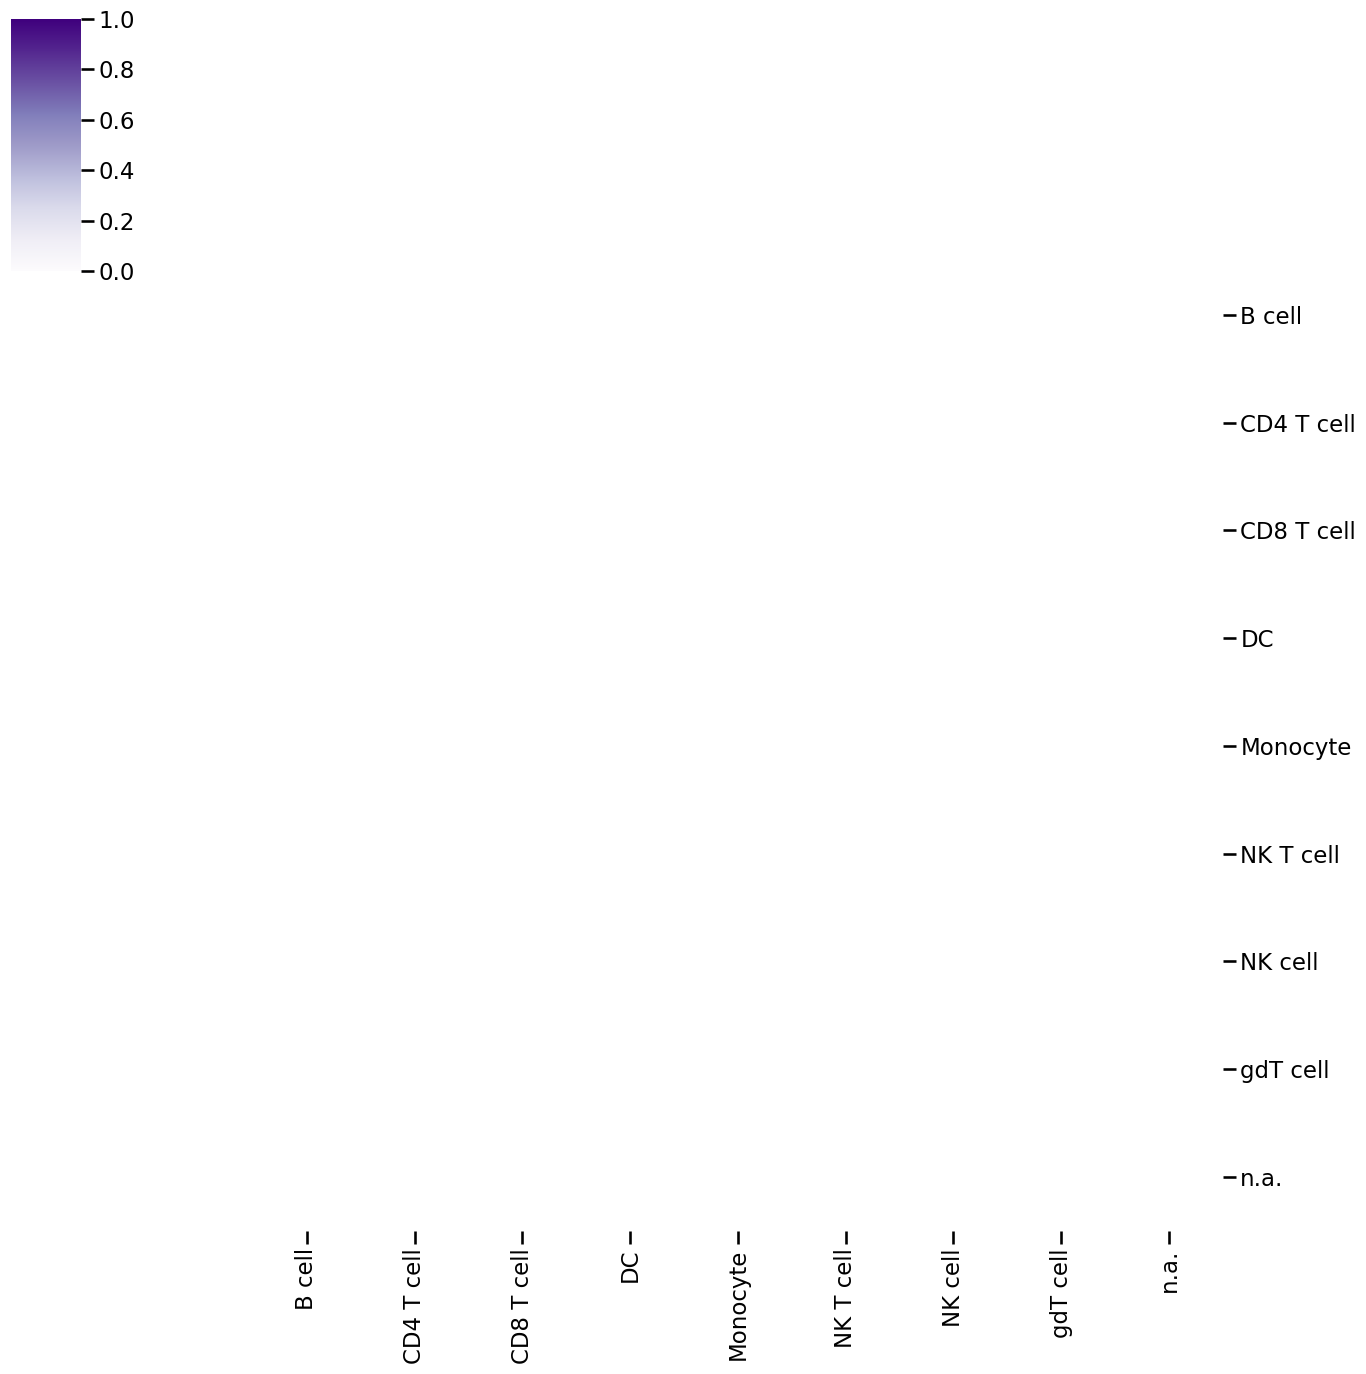

In [43]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

## Appendix: Reference mapping on Lung-Kim dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).

In [ ]:
referenceData = sc.read_h5ad('../../data/lung/sample_proc_lung_train.h5ad')
queryData = sc.read_h5ad('../../data/lung/sample_proc_lung_test.h5ad')

sc.pp.normalize_total(referenceData, target_sum=1e4)
sc.pp.log1p(referenceData)
sc.pp.normalize_total(queryData, target_sum=1e4)
sc.pp.log1p(queryData)

gene_col = "gene_name"
cell_type_key = "cell_type"

In [ ]:
ref_embed_referenceData = scg.tasks.embed_data(
    referenceData,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
test_embed_queryData = scg.tasks.embed_data(
    queryData,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# concatenate the two datasets
referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")
# mark the reference vs. query dataset
referenceData_concat.obs["is_ref"] = ["Query"] * len(test_embed_queryData) + ["Reference"] * len(
    ref_embed_referenceData
)
referenceData_concat.obs["is_ref"] = referenceData_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"

In [ ]:
sc.pp.neighbors(referenceData_concat, use_rep="X_scGPT")
sc.tl.umap(referenceData_concat)
sc.pl.umap(
    referenceData_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [30]:
ref_cell_embeddings = ref_embed_referenceData.obsm["X_scGPT"]
test_embed = test_embed_queryData.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_referenceData.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = queryData.obs[cell_type_key].to_numpy()

In [ ]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

In [ ]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,
                    fmt=".2f", 
                    annot_kws={'size': 16}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))